# Table of contents
1. [Quick Start and an Example](#introduction)
2. [aPRAM Classes and Methods](#ClassesAndMethods)
    1. [Populations](#Pop)
    2. [Columns](#Column)
    3. [Cohort](#Cohort)
    4. [Params and Counters](#Param)
    5. [Mods](#Mod)
    6. [Mod Selectors](#Mod_Selector)
    7. [Simulators](#Sim)
3. [aPRAM Main Loop](#loop)
4. [Some Technical Details](#details)
    1. [Multinomial Sampling](#multinomial_sampling)
    2. [When-needed evaluation](#when_needed)
    3. [aPRAM expression language](#expression_language)

<a name="introduction"></a>
# Quick Start # 


aPRAM is a framework for building probabilistic, relational agent-based systems (PRAMs).  The central ideas in aPRAM are: 

- To vectorize computation for speed;
- To make agents behave stochastically rather than deterministically;
- To make behaviors depend on relations between agents

aPRAM is built on [Numpy](https://numpy.org/doc/stable/user/quickstart.html), so most operations are vectorized and relatively fast.  You don't need to know Numpy to read this tutorial or build aPRAM models but eventually you'll want to learn it. 

The goal of this tutorial is to introduce aPRAM's main classes and methods so you can see how to build and control aPRAM simulations.   The use case throughout will be simulations of epidemics, so we'll be concerned with health status and interventions such as quarantine and mandatory mask-wearing.

We will begin this tutorial an aPRAM implementation of a "compartmental" model of epidemic dynamics and a little experiment to explore the efficacy of self-quarantine.  After that, we will go back over parts of the model to introduce aPRAM's main classes and methods.  

## The SEIRD model and a quarantine intervention in aPRAM ## 

We'll illustrate aPRAM by implementing the well-known [SEIRD model of epidemics](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology). The model says that at each time step, the population is divided between five *compartments* called Susceptible, Exposed, Infected, Recovered and Dead.  We'll code these health states of agents with the integers 0,1,2,3,4, respectively, so `health==3` means an agent is Infected, or, equivalently, in the Infected compartment.    

Susceptible agents become exposed with a probability proportional to the number of infectious agents (i.e., as more of the population becomes infectious, the probability that a susceptible agent will encounter an infectious agent increases). The disease incubates in Exposed (`health == 1`) agents over a period of days.  We will assume that Exposed agents are asymptomatic, meaning that they can spread the disease but don't exhibit symptoms.  Exposed, asymptomatic agents may become Infected, symptomatic (`health == 2`) or may Recover (`health==3`) without ever showing symptoms.  Infected agents transition to Recovered (`health == 3`) or Dead (`health == 4`).  These transitions take different amounts of time for different agents.  

The simulated dynamics of an epidemic is represented by the relative sizes of the five compartments over time.  In fast-moving epidemics, the number of infectious individuals (those with `health == 1` or `health == 2`) rises exponentially.  When public health experts speak of "flattening the curve," they mean slowing the rate at which Susceptible individuals become Exposed, keeping the Exposed and Infected compartments relatively small so that there will be fewer agents to spread the disease. 

The following code block is the entire SEIRD model in aPRAM as well as an experiment to explore the effects of self-quarantine.  You can run the block to see what happens, but we recommend that you read it -- especially the comment strings -- first. 

Ready to plot the results...


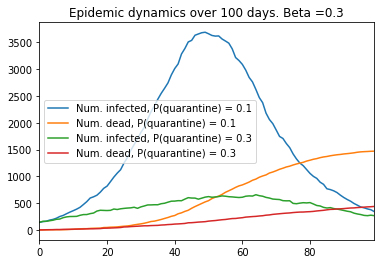

In [29]:
import numpy as np
# stuff for random sampling
from numpy.random import default_rng
rng = default_rng() 

# stuff for collecting simulation data
import pandas as pd 
import matplotlib.pyplot as plt

# aPRAM stuff
import aPRAM_utils as utils
from aPRAM_expressions import WN
from aPRAM_settings import pop,sim

"""
aPRAM_settings creates a population called pop and a simulator called sim.  Both are
"empty" but will be "filled in" as the model is developed. However, all aPRAM classes 
need to know the population size, so this is the first thing to set after pop and 
sim have been imported.
"""

pop.size = 100000

# reset 
pop.reset ()
sim.reset ()

"""
Agent attributes are stored in objects called Columns.  The pop.make_column method
creates a column of length pop.size and registers it with the population pop.  In this
case we need only two attributes, health status and quarantine status.  Initially, 
every agent's health status is 0, which will mean 'Susceptible' and quarantine status 
is also 0, which means 'not quarantined'. 
"""

pop.make_column('health',np.zeros(pop.size))
pop.make_column('quarantined', np.zeros(pop.size))


"""
Cohorts are subsets of populations.  The method pop.make_cohort creates a Cohort
object and registers it with the population pop.  Cohorts usually are dynamic, 
which means that thir membership can change during a simulation (e.g., an agent in
the 'Infected' cohort can recover, moving to the 'Recovered' cohort).  Cohorts thus 
have boolean membership criteria that are evaluated "when needed".  Here we define 
five cohorts for the five epidemiological compartments in the SEIRD model.  For instance, 
the first definition says, "when needed, the membership of cohort S is those agents 
whose health status equals 0."
"""

pop.make_cohort('S',WN(pop.health.eq,0)) # Susceptible agents
pop.make_cohort('E',WN(pop.health.eq,1)) # Exposed (aymptomatic) agents
pop.make_cohort('I',WN(pop.health.eq,2)) # Infected (symptomatic) agents
pop.make_cohort('R',WN(pop.health.eq,3)) # Recovered agents
pop.make_cohort('D',WN(pop.health.eq,4)) # Deceased agents

"""
We will also define a cohort of infectious agents to be those agents who are
not quarantined and have health status equal to 1 or 2 ('Exposed' or 'Infected').
"""

pop.make_cohort('F', # InFectious agents
                (lambda : np.logical_and(
                    pop.quarantined.eq(0),
                    (np.logical_or (pop.health.eq(1), pop.health.eq(2))))))

"""
The Q cohort is all the agents whose quarantine status equals 1, meaning 'in quarantine'.
"""
pop.make_cohort('Q', WN(pop.quarantined.eq,1))  # Quarantined agents


"""
We also will need a "population cohort" whose members are all the agents in the population.
Note that this cohort is not dynamic, meaning that agents cannot enter or leave the
population cohort.  Some epidemiological models include births and deaths of population
members, in which case the population membership would be dynamic.  
"""
pop.make_cohort('P', (lambda: np.ones(pop.size).astype(bool)), dynamic=False)


"""
Occasionally, aPRAM needs the modeler to define domain-specific functions.  Here we
define the probability of transmission of disease between agents. Domain-specific
functions can refer to aPRAM objects; in this case, p_transmission depends on an 
aPRAM parameter called beta and also on the Cohorts F and S.  
"""

pop.make_param('beta', .3)
pop.make_param ('p_quarantine',[.2,.8])

def p_transmission (beta):
    # Infectious agents -- those in cohort F -- can transmit infections
    # The probability of being an infectious agent is:
    p_infectious = pop.F.size / pop.size

    # Similarly, the probability of being a Susceptible agent is:
    p_susceptible = pop.S.size / pop.size

    # The probability that one meeting between two agents has one
    # infectious and one Susceptible is:
    p_one_potential_transmission = p_infectious * p_susceptible

    # Potential transmissions become actual transmissions with
    # probability beta:
    p_one_transmission = p_one_potential_transmission * beta

    # return both probability of transmission and its complement,
    # as Mods will need both

    return [p_one_transmission, 1 - p_one_transmission]



"""
Now it's time to define the actions that set up and animate simulations.  The
simulation method sim.make_mod creates Mods, which tell aPRAM what to do. 
Each Mod applies to exactly one cohort and has a list of 'modlists'.  Each
modlist is a list of actions.  For example, the initialize_attributes Mod applies
to Cohort P -- the entire population -- and has one modlist of two actions. The 
first action says "when needed, set the value of health to 0."  
"""

sim.make_mod(
    name= 'initialize_attributes',
    cohort = pop.P,
    mods = [ [WN(pop.health.assign,0), WN(pop.quarantined.assign,0) ] ],
    sim_phase = 'setup'
)


"""
The seed_infections Mod has two modlists, each of which has one action.  Whenever 
there is more than one modlist, aPRAM needs a method to decide which agents are 
subject to which modlists.  This decision is always probabilistic and is controlled
by the prob_spec argument.  The seed_infections Mod says that with probability .001,
an agent will have its health status set to 1 (i.e., 'Exposed'), otherwise it will 
have health status set to 0 (i.e., 'Susceptible').  This Mod applies to the entire
population and runs during the 'setup' phase of the simulation.  Its effect is to
seed the population with a small proportion of Exposed agents.
"""

sim.make_mod(
    name = 'seed_infections',
    cohort = pop.P,
    mods = [[WN(pop.health.assign,1)],
            [WN(pop.health.assign,0)]
            ],
    prob_spec = (.001,.999),
    sim_phase= 'setup'
    )


""" 
The following susceptible_to_exposed Mod runs during the 'loop' phase of the 
simulation (i.e., on each time step) and drives the epidemic dynamics.  It 
applies only to the S Cohort, and its job is to make some Susceptible agents sick.
It has two modlists.  The first says 'when needed, set health status to 1'.  The
second is an empty list, which is aPRAM's convention for doing nothing. 

The characteristic feature of epidemics is that the probability
of exposure increases as more and more people get sick, so the prob_spec
argument is dynamically re-evaluated on each time step of the simulation.
It calls the p_transmission function we defined earlier.  The prob_spec says 
'when needed, evaluate p_transmission and align the probabilities it returns 
with the modlists.'  The function p_transmission returns two probabilities, 
p and 1-p, where p is the probability of transmission.  In effect, p becomes
the probability of the first modlist, so p * pop.size agents become sick,
while 1-p becomes the probability of the do-nothing modlist.
"""

# This drives the epidemic dynamics:  The probability
# of becoming Exposed depends on p_transmission and beta
sim.make_mod(
    name= 'susceptible_to_exposed',
    cohort = pop.S,
    mods = [[WN(pop.health.assign,1)],
            [] ],
    prob_spec = WN(p_transmission,pop.beta),
    sim_phase = 'loop'
)

# Exposed agents can become Infected, Recovered or remain Exposed
sim.make_mod(
    name = 'exposed_to_next',
    cohort = pop.E,
    mods = [ [WN(pop.health.assign,2)],   # Exposed transition to Infected
             [WN(pop.health.assign,3)],   # Exposed transition to Recovered
             [] ],                          # Do nothing (remain Exposed)
    prob_spec = (.2,.2,.6),
    sim_phase = 'loop'
    )

# Infected agents can become Recovered, Dead or remain Infected
sim.make_mod(
    name = 'infected_to_next',
    cohort = pop.I,
    mods = [ [WN(pop.health.assign,3)],   # Infected transition to Recovered
             [WN(pop.health.assign,4)],   # Infected transition to Dead
             [] ],                          # Do nothing
    prob_spec = (.1,.01,.89),
    sim_phase = 'loop'
    )

"""
The Mods above are all we need to generate disease dynamics for the SEIRD 
model, but we'd also like to explore the efficacy of self-quarantine.  
We begin by defining an aPRAM parameter  that contains the probabilities  
of quarantining and doing nothing.  We'll experiment with these probabilities 
to see their effect on epidemic dynamics.
"""

pop.p_quarantine.val = [.1,.9]

"""
Next we'll define a Mod that puts people into quarantine or not with the given 
probabilities. This Mod applies to the Infected Cohort only.  That is, agents
quarantine only when they show symptoms.  We could also make Mod apply to Cohort F, 
which includes Exposed and Infected individuals, or to simulate the benefits of 
contact tracing we could write other Mods to represent knowing that one has been 
in contact with an infectious agent.
"""

sim.make_mod(
    name = 'quarantine',
    cohort = pop.I,
    mods = [ [WN(pop.quarantined.assign, 1)],  
              [] ],
    prob_spec = WN(pop.p_quarantine),
    sim_phase = 'loop'
    )

"""
Set up the data gathering -- this will be easier and more intuitive in future 
versions of aPRAM; ignore it for now.
"""

def probe_fn (day):
    record = [day, sim.susceptible_to_exposed.mod_selector.probs[0]]
    record.extend([c.size for c in [pop.S,pop.E,pop.I,pop.R,pop.D,pop.F,pop.Q]])
    return record

probe_labels = ['day','p','S','E','I','R','D','F','Q']



"""
Set up the simulation.  aPRAM has set up a Sim object called sim "behind the 
scenes"; we'll look at it later. For now, we need only tell sim how many 
iterations to run and which functions to use to collect data.
"""

sim.num_iterations  = 100
sim.probe_labels    = probe_labels
sim.probe_fn        = probe_fn

"""
Now we will test the efficacy of quarantine.  We'll run two simulations, 
the first with a low probability of quarantine, the second with a 
higher probability.  We'll store the data generated by each simulation in 
a pandas frame and then plot it.
"""

# set beta however you want
pop.beta.val = .3
# set a low probability of quarantine, record it for plotting
pop.p_quarantine.val = [.1,.9]
plot_label_0 = str(pop.p_quarantine.val[0])

# tell sim to run
sim.run_simulation()

# store sim.records -- the data -- in a pandas dataframe
df1 = pd.DataFrame(sim.records,columns=probe_labels)

# reset sim.records so we can re-run sim
sim.records=[]

# set a higher probability of quarantine, rerun sim and collect data
pop.p_quarantine.val = [.3,.7]
plot_label_1 = str(pop.p_quarantine.val[0])
sim.run_simulation()
df3 = pd.DataFrame(sim.records,columns=probe_labels)
sim.records=[]

print("Ready to plot the results...")


# plot the results
ax = df1['F'].plot(label = 'Num. infected, P(quarantine) = '+plot_label_0)
df1['D'].plot(ax=ax, label = 'Num. dead, P(quarantine) = '+plot_label_0)
df3['F'].plot(ax=ax, label = 'Num. infected, P(quarantine) = '+plot_label_1)
df3['D'].plot(ax=ax, label = 'Num. dead, P(quarantine) = '+plot_label_1)
ax.legend()
plt.title(label = 'Epidemic dynamics over '+str(sim.num_iterations)+' days. Beta ='+str(pop.beta.val))
plt.show()

<a name="ClassesAndMethods"></a>
# aPRAM's Classes and Methods #

aPRAMS classes are:

    Pop, the class of populations
    Sim, the class of simulators
    Column, the class of agent attributes
    Parameter, a catchall class for storing state information other than agent attributes
    Cohort, the class of groups of agents that satisfy a logical condition
    Mod, the class of actions that change agent attributes and other state information
    Mod_Selector, the class that probabilistically assigns actions to agents
    Act, the class of actions

You can think of an aPRAM population as a two-dimensional table in which rows represent agents and columns represent agent attributes such as age or health status.  In actuality, the overhead of handling very large two-dimensional arrays is high, so a population is implemented as a bundle of one-dimensional Numpy arrays, called Columns, each of which represents a single agent attribute. The $i$th element in Column $a$ contains the value of attribute $a$ for agent $i$.  Groups of agents, called Cohorts, are identified by boolean functions on Columns; for example, there is a Cohort of agents whose health status is infected AND whose quarantine status is non-quarantined.  Cohorts are generally *dynamic*, meaning that their membership can change over time; for example, new agents can become infected and previously non-quarantined agents can enter quarantine.  

Actions are specified by an aPRAM class called Mods.  The important elements of a Mod are the Cohort to which it applies; one or more a lists of actions, called modlists; and a method for deciding which agents in the Cohort are assigned to which modlists. Thus, different Cohorts will experience different Mods, or the same Mod may apply to 
different Cohorts but with different probabilities.  For example, a Mod for hospitalization will apply only to Cohorts of infected agents, but infected elderly agents are more likely to be hospitalized than infected young agents.  While some actions are deterministic, aPRAM is designed for the general case where a multinomial probability distribution controls which actions apply to which agents in a Cohort.  For example, in a given Cohort of infected agents, the probabilities of remaining infected, becoming hospitalized, recovering or dying are controlled by a multinomial distribution over these four outcomes. 

Just as Cohorts can be dynamic, so can probabilities of actions.  For example, the probability of an action that transmits infection will depend on the number of people who are infected, which changes over time.  

Before we go on, a word needs to be said about "when needed" computation.  Python and Numpy evaluate expressions immediately, whereas simulations need a way to evaluate expressions not immediately but in future contexts. Python is a bit like a dog that gets excited when it hears the word "walk".  You can't say to the dog, "don't get excited now, but I intend to take you on a walk later this afternoon."  aPRAM has a language for expressing computations that will happen in future contexts.  You can [read about it](when-needed) before working through the current section of the tutorial, but you don't need to: Just keep in mind that expressions wrapped in WN are evaluated "when needed" and don't worry if the syntax of WN expressions seems peculiar.

<a name="Pop"></a>
## Populations ## 

`Pop` is the class of aPRAM populations.  Lowercase `pop` is the  default name for a population instance. The size of  population `pop` is called `pop.size`. All aPRAM classes need to know the population size, so setting it is the first thing we do:

In [30]:
# Set the population size
pop.size = 100000  

# Reset in case you want to re-run this notebook with a refreshed pop and sim
pop.reset ()
sim.reset ()

The Pop class methods are:

- make_column(name,values):  makes a column with given name and values
- make_parameter (name, *value=None*,*update_fn=None*,**args*): makes a Parameter with optional value, update_fn and *args
- make_cohort (name, sexpr, *dynamic=True*): make a Cohort that has sexpr as its when-needed boolean membership criteria. Cohorts can be static or dynamic, with dynamic being the default. 
- make_counter (name, *initial_value=0*,*increment=1*): Make a counter with the given name and default initial value 0 and increment size 1.
- reset (): This deletes all the parameters, counters, columns, and static and dynamic cohorts, and resets the lists that contain these entities to []. It preserves pop.size, only.
- describe(*level = 0*): builds an f-string description of the population

All the 'make' methods register the names with the population, which is a subclass of a Python SimpleNamespace. 

Pop attributes are:

- `size` -- the size of the population, i.e., the number of agents or equivalently the length of Columns
- `columns`-- a list of columns i.e., agent attributes
- `params` -- a list of population parameters
- `counters` -- a list of counters
- `static_cohorts` -- a list of Cohorts that are defined once and never updated
- `dynamic_cohorts` -- a list of Cohorts whose membership is updated on each simulation cycle


<a name="Column"></a>
## Columns ## 

The `Column` class is used to represent attributes and relations such as health and membership in groups.  The $i$th value in any Column corresponds to the $i$th agent in a population. 

The Column class methods are:

- `lt,le,gt,ge,eq,ne`, which test whether column values are less than, less than or equal to, greater than, greater than or equal to, equal and not equal to some value.  These methods return Numpy boolean arrays.
- `assign` assigns a value or an array of values to a Column
- `get_val` returns the value of the Column, which is a Numpy array
- `itself` returns the Column instance itself
- `describe` builds an f-string description of the column

Column attributes are:

- `name` - the name of the column/agent attribute
- `val` - a one-dimensional Numpy array of length pop.size

If you were modeling a real population, then columns and their values would come from published databases, but for this tutorial we will make them up.  Let us add `health` and `quarantined` and `age_group` as agent attributes (ignore the expressions to the right of the column names for now).  To make the results of the following code blocks more readable, we will reset the population size to be very small:

In [31]:
pop.size = 30

# initial value for health is 0, meaning Susceptible. 
pop.make_column('health',np.zeros(pop.size).astype(np.int8))

# initial value for quarantined is 0, meaning not quarantined
pop.make_column('quarantined', np.zeros(pop.size).astype(np.int8))

# initial values for age_group are 0, 1, 2, 3 meaning minor, young adult, 
# adult and old. These age groups make up 10%, 20%, 35% and .35% of the 
# population, respectively

pop.make_column('age_group',rng.choice(4,p=(.1, .2,.35,.35),size=pop.size))


Note that columns "belong to" a population and are named accordingly.  If we look at `pop`, we'll see the Columns that we just defined.

In [32]:
print(pop.describe())

size: 30
Counters:
Params:
Columns:
   Column:
      name health
      val: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
   Column:
      name quarantined
      val: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
   Column:
      name age_group
      val: [1 3 2 3 1 2 2 3 3 2 2 2 2 2 0 0 2 1 2 1 3 0 1 3 2 2 1 2 2 2]
Static cohorts:
Dynamic cohorts:



Let's exercise some Column methods:

In [33]:
print(pop.age_group.val)  # age group values 

# pop.age_group.val is an attribute, whereas pop.age_group.get_val is a method
print(pop.age_group.get_val()) 

# Let's test which agents are in age_group 3. Note that the result is a 
# Numpy boolean array

print(pop.age_group.eq(3))

# To make it a bit clearer, we can recast the boolean array as an array of
# 1 or 0 (for True and False) and look at just the first 20 values:

print(f"\n{pop.age_group.val}\n{pop.age_group.eq(3).astype(int)}")

[1 3 2 3 1 2 2 3 3 2 2 2 2 2 0 0 2 1 2 1 3 0 1 3 2 2 1 2 2 2]
[1 3 2 3 1 2 2 3 3 2 2 2 2 2 0 0 2 1 2 1 3 0 1 3 2 2 1 2 2 2]
[False  True False  True False False False  True  True False False False
 False False False False False False False False  True False False  True
 False False False False False False]

[1 3 2 3 1 2 2 3 3 2 2 2 2 2 0 0 2 1 2 1 3 0 1 3 2 2 1 2 2 2]
[0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0]


Numpy's `sum` method counts the number of True values in an array, and thus tells us the number of agents who pass a test on Column values.  Numpy's `where` method tells us the indices of agents that pass a test:

In [34]:
print(pop.age_group.val)
print(np.sum(pop.age_group.eq(3)))
print(np.where(pop.age_group.eq(3)))

[1 3 2 3 1 2 2 3 3 2 2 2 2 2 0 0 2 1 2 1 3 0 1 3 2 2 1 2 2 2]
6
(array([ 1,  3,  7,  8, 20, 23]),)


Most actions in aPRAM change the values of agent attributes.  It's important to be able to do this selectively.  For example, we might want to change the health values of agents depending on their age_group values:

In [35]:
# This assigns the value 1 to health status of all agents whose age_group value is 3: 
pop.health.assign(1,selected = pop.age_group.eq(3))

print(pop.age_group.val)
print (pop.health.val)

[1 3 2 3 1 2 2 3 3 2 2 2 2 2 0 0 2 1 2 1 3 0 1 3 2 2 1 2 2 2]
[0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0]


The `assign` method requires that the values to be assigned can be 'broadcast' in the Numpy sense to the Column values.  For example, we can assign an array of the same length as a Column or a single value:

In [36]:
# assign random integers in the open interval 0..10:
pop.health.assign(rng.integers(0,10,pop.size))
print(pop.health.val)

# assign a single value:
pop.health.assign(0)
print(pop.health.val)


[8 5 5 7 9 7 2 5 9 5 3 0 1 1 6 3 7 3 6 5 5 8 5 3 7 4 1 8 9 7]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


<a id='cohorts'></a>
<a name="Cohort"></a>
### Cohorts ###

An aPRAM expression `pop.age_group.le(1)` implicitly identifies a group of agents, but often we need to refer to the group itself, not just the criteria for being in the group.  

`Cohort` is an aPRAM class that explicitly identifies particular agents in the population. Each cohort has a name and selection criteria that determine whether an agent should be in the cohort. Cohort methods are:

- `select` applies the cohort's membership criteria to the population and sets two cohort attributes: `size` contains the number of agents who satisfy the membership criteria and `members` contains the indices of agents that satisfy the criteria
- `get_members` returns the cohort members 
- `describe` builds an f-string description of the cohort.

Cohort attributes are:

- `members` -- the indices of cohort members
- `size` -- the number of cohort members
- `dynamic`-- whether the cohort membership is updated on each iteration of the simulator.  The default value is True. 

Let's reset the population size to be larger, redefine the columns `health` and `quarantined`, and once again define the cohorts for the epidemiological example:

In [37]:
pop.size = 100000
pop.reset()
pop.make_column('health',np.zeros(pop.size))
pop.make_column('quarantined',np.zeros(pop.size))

pop.make_cohort('S',WN(pop.health.eq,0)) # Susceptible agents
pop.make_cohort('E',WN(pop.health.eq,1)) # Exposed (aymptomatic) agents
pop.make_cohort('I',WN(pop.health.eq,2)) # Infected (symptomatic) agents
pop.make_cohort('R',WN(pop.health.eq,3)) # Recovered agents
pop.make_cohort('D',WN(pop.health.eq,4)) # Deceased agents


pop.make_cohort('F', # InFectious agents
                (lambda : np.logical_and(
                    pop.quarantined.eq(0),
                    (np.logical_or (pop.health.eq(1), pop.health.eq(2))))))

pop.make_cohort('Q', WN(pop.quarantined.eq,1))  # Quarantined agents

# We also will need a "population cohort" whose members are all the agents in the population:
pop.make_cohort('P', (lambda: np.ones(pop.size).astype(bool)), dynamic=False)

# print the size and membership of the Susceptible Cohort
print(f"Susceptible cohort size: {pop.S.size}, members: {pop.S.members}")


Susceptible cohort size: 100000, members: [    0     1     2 ... 99997 99998 99999]


Note that Cohorts "belong to" populations just as Columns do. To define a cohort, we pass a name and (usually) a when-needed (WN) expression that tells the cohort how to select its members.  WN expressions are parsed into functions that are evaluated when needed by invoking a Cohort's `select` method.  This allows Cohorts to update their membership dynamically during simulations. 

For example, the WN expression `(pop.quarantined.eq, 1)` instructs aPRAM to create a function that will test whether `pop.quarantined == 1`.  The Cohort `select` method runs this function when needed, allowing aPRAM to update Cohort membership dynamically.  

Let's illustrate when-needed evaluation of Cohort membership:


In [38]:
# See who is in cohort Q right now:
pop.Q.select()
print(pop.Q.members)
print()

# Suppose a random 15 members of the population go into quarantine.
# We'll do this manually here and later show how to do it in aPRAM
random_quarantiners = rng.choice(pop.size,15) 
pop.quarantined.assign(1, selected = random_quarantiners) 

# Now if we run Q.select again, Q's membership will be updated:
pop.Q.select()
print(pop.Q.members)

# Each time you run this block, another 15 random agents will be added to 
# cohort Q (except in the improbable case that one or more is already in Q)

[]

[ 2124 13860 23908 33199 33871 35416 41173 51691 54593 57963 67210 74560
 88363 98560 98827]


### The Population Cohort P
<a id='P'></a>

Cohorts like `S` and `Q` allow aPRAM to do different things to different subsets of the population, but what if you want to do something to the entire population?  We defined a 'population cohort' called P that includes as its members the entire population:  

In [39]:
print(pop.P.describe())

Cohort:
   name P
   size: 100000
   members: [0, 1, 2 ... 99997, 99998, 99999]
   selector: <function <lambda> at 0x11c19fcb0>
   selected: [ True  True  True ...  True  True  True]


<a name="Param"></a>
### Population Params and Counters ###

Columns and Cohorts represent two kinds of state information that can change during a simulation.  Columns represent agent attributes and Cohorts represent groups of agents.  Population Params are a third, catchall mechanism for representing state information.  

Param methods are:

- `update` applies a param's `updater`, which is usually a when-needed (WN) expression or a lambda expression.
- `assign` sets the `val` attribute of a param.
- `get_val` returns the `val` attribute of a param.
- `itself` returns the param object, itself
- `describe` builds an f-string representation of the param

The only attribute of a param is its `val`.

Counters are a param-like class whose `update` method increases `val` by an given increment.  

Let's define two parameters and a counter for our epidemiological example:


In [40]:
# make_parameter creates a Parameter object
# specify a parameter name and an initial value
pop.make_param ('beta',.3)
pop.make_param ('p_quarantine',[.1,.9])
pop.make_counter ('day',initial_value=0,increment=1)

print (pop.beta.describe())
print (pop.p_quarantine.val) 

# the parameter assign method is used to assign a value
pop.p_quarantine.assign([.2,.8])
print (pop.p_quarantine.val)


Param:
   Name beta
   Val: 0.3
[0.1, 0.9]
[0.2, 0.8]


<a name="Mod"></a>
### Changing the states of agents through Mods ###

So far, we have set up attributes of agents (i.e., Columns) and groups of agents (i.e., Cohorts) but we haven't said how to make an aPRAM simulation *do* anything.  In aPRAM, most actions are specified by Mods.  `Mod` is an aPRAM class that specifies modifications to the population.  Mods modify agents in cohorts by probabilistically changing their attribute values. 

`Mod` methods are:

- `select` calls the `Mod_Selector` if one is associated with the Mod.  The `Mod_Selector` decides which agents are subject to which Mod actions  
- `do-mods` implements the Mod actions 
- `describe` builds an f-string representation of the Mod

The attributes of Mods are:

- `name` --  Just as Cohorts and Columns and Parameters "belong to" a population, 
Mods belong to a simulator the default name of which is `sim`.
- cohort -- the cohort of agents to which the mod will be applied
- mods -- a list of modlists, where each modlist is a list of actions
- mod_selector -- this could be None, but a Mod has more than one modlist, then it needs a Mod_Selector to decide which agents are subjected to which modlist
- prob_spec -- probabilities associated with modlists
- sim_phase -- `setup` if the Mod is used to set up the simulation, `loop` if Mod is evaluated on each cycle of the simulation

For example, here are two Mods that we'll use to initialize our epidemiological simulation:


In [41]:

# set health to 0 and quarantined to 0
sim.make_mod(
    name= 'initialize_attributes',
    cohort = pop.P,
    mods = [ [WN(pop.health.assign,0), WN(pop.quarantined.assign,0) ] ],
    sim_phase = 'setup'
)


# Specify two modlists that will happen with the given probabilities 

sim.make_mod(
    name = 'seed_infections',
    cohort = pop.P,
    mods = [[WN(pop.health.assign,1)],
            [WN(pop.health.assign,0)]
            ],
    prob_spec = (.001,.999),
    sim_phase= 'setup'
    )



The first Mod, `sim.initialize_attributes`, has one *modlist* that contains two *actions*.  The actions are to assign the value 0 to `pop.health` and assign 0 to `pop.quarantined`.  This Mod applies to the cohort `P`, that is, the entire population.

The `seed_infections` Mod has two modlists, each containing one action.  It, too, applies to cohort `P`.  

Whenever a Mod has more than one modlist, aPRAM must decide which modlist to apply to each agent. <b>*This decision is always probabilistic*</b>: Every agent in a Mod's specified cohort will have exactly one modlist from that Mod applied to it based on probabilities specified in the Mod's `prob_spec`.  For example, the probabilities in `seed_infections` specify that, in expectation, 0.1% of the agents, *selected at random*, will have their `health` attribute set to 1, while the remaining 99.9% of the agents will have their `health` set to 0. 

However, Mods generally will not divide cohorts into subsets of *exactly* the expected sizes because the selection of agents is done by sampling from probability distributions.  

Let's run these Mods:

In [42]:
# reset health and quarantined values and rerun cohort Selectors
# for Susceptible, Exposed, Infected and inFectious cohorts
sim.initialize_attributes.do_mods()

# seed the population with .001 Exposed individuals
sim.seed_infections.do_mods()

# Rerun the cohort selectors to update cohort memberships and print their descriptions
for cohort in [pop.S, pop.E, pop.I, pop.F]: 
    cohort.select()
    print(cohort.describe(print_selector=False))
    

Cohort:
   name S
   size: 99909
   members: [0, 1, 2 ... 99997, 99998, 99999]

Cohort:
   name E
   size: 91
   members: [1622, 1869, 4031 ... 95683, 96467, 99988]

Cohort:
   name I
   size: 0
   members: []

Cohort:
   name F
   size: 91
   members: [1622, 1869, 4031 ... 95683, 96467, 99988]



As expected, the `seed_infections` mod set roughly one one-thousandth of the population to have `health == 1` while the rest have `health == 0`; so when the Cohort selectors ran, these agents ceased to be in cohort `pop.S` -- the Susceptible cohort -- and became members of cohort `pop.E`, the Exposed cohort.

Note the sizes of the cohorts and also their membership lists, which contain the indices of the agents in population `pop`.  The membership lists for cohorts `S` and `E` are disjoint because agents cannot be both Susceptible and Exposed. In general, one agent can appear in multiple cohorts provided the selection criteria for these cohorts are not mutually exclusive.  For example, the membership of `E` and `F` is currently identical, though when agents become Infected or Quarantined, `E` and `F` will no longer contain exactly the same agents. 

The membership of Cohort `I` is empty because we haven't written any Mods yet to effect transitions from being Exposed to being Infected. 

Now that some members of the population are infectious, let's model transmission of disease between infectious and susceptible agents.  The more infectious agents there are, the more likely it is that a Susceptible agent will meet an infectious agent. When these meetings happen, infection is transmitted with a probability commonly called $\beta$.  We defined an aPRAM Parameter for $\beta$ earlier.  Here is a function to calculate the probability of transmission at a meeting of two randomly selected agents for a given value of $\beta$:

In [43]:
# define a parameter called beta and set its value to 0.1
pop.make_param('beta', .1)

# define a function to compute probability of transmission

def p_transmission (beta):
    # The probability of being an infectious agent is the size
    # of F the infectious cohort, divided by the population size
    p_infectious = pop.F.size / pop.size
    
    # Similarly, the probability of being a Susceptible agent is:   
    p_susceptible = pop.S.size / pop.size
    
    # The probability that one meeting between two agents has one
    # infectious and one Susceptible is:  
    p_one_potential_transmission = p_infectious * p_susceptible
    
    # Potential transmissions become actual transmissions with 
    # probability beta:  
    p_one_transmission = p_one_potential_transmission * beta
    
    # return both probability of transmission and its complement,
    # as Mods will need both
    
    return [p_one_transmission, 1 - p_one_transmission]

print (p_transmission(pop.beta.val))

# we can change the value of beta and see how it affects 
# the probability of transmission:

pop.beta.assign(.3)
print (p_transmission(pop.beta.val))


[9.091719000000001e-05, 0.99990908281]
[0.00027275157, 0.99972724843]


Now we can define a Mod that will change the health status of members of cohort `S` with the probability we just defined:

In [44]:
sim.make_mod(
    name= 'susceptible_to_exposed',
    cohort = pop.S,
    mods = [[WN(pop.health.assign,1)],
            [] ],
    prob_spec = WN(p_transmission,pop.beta),
    sim_phase = 'loop'
)

Note that this Mod applies only to cohort `S` and it specifies only one "real" modification, namely, changing health status to 1.  But actually, the intent of the Mod is to change `health` for a fraction of cohort `S` and do nothing to the rest of the cohort. This is indicated by the empty brackets in the `mods` argument, which is aPRAM's convention for "do nothing".  Now we see why the function `p_transmission` returns a list of *two* probabilities: The first is the probability of setting `health` to 1, the second is the probability of doing nothing.

We tell aPRAM that this Mod should run on every time step of the simulation by specifying that it is a `loop` Mod.  

Later we will introduce the Sim class that repeatedly runs Mods and updates Cohorts, but for the moment we can run the `susceptible_to_exposed` mod repeatedly and see how the probability of transmission and the size of the Exposed cohort increases:

In [45]:
# reset health attribute and re-seed the population with some Exposed individuals
sim.initialize_attributes.do_mods()  
sim.seed_infections.do_mods()

# play around with beta:
pop.beta.assign(.3)

# recalculate cohort membership
for cohort in [pop.S, pop.E, pop.I, pop.F]: cohort.select() 

# Test the effects of sim.susceptible_to_exposed
for i in range(40):
    print (f"{i:3d} {p_transmission(pop.beta.val)[0]:.4f}, {pop.E.size}")
    sim.susceptible_to_exposed.select()   # select which agents get which modlist
    sim.susceptible_to_exposed.do_mods()  # do the mods
    for cohort in [pop.S, pop.E, pop.I, pop.F]: cohort.select() # update cohort membership
    

  0 0.0003, 91
  1 0.0004, 120
  2 0.0005, 151
  3 0.0006, 195
  4 0.0008, 251
  5 0.0009, 315
  6 0.0012, 406
  7 0.0016, 524
  8 0.0020, 687
  9 0.0026, 879
 10 0.0034, 1143
 11 0.0044, 1502
 12 0.0057, 1938
 13 0.0074, 2542
 14 0.0095, 3284
 15 0.0121, 4218
 16 0.0154, 5431
 17 0.0195, 6972
 18 0.0239, 8715
 19 0.0291, 10874
 20 0.0348, 13400
 21 0.0410, 16349
 22 0.0477, 19846
 23 0.0542, 23661
 24 0.0601, 27737
 25 0.0654, 32149
 26 0.0697, 36684
 27 0.0727, 41168
 28 0.0744, 45597
 29 0.0750, 49656
 30 0.0746, 53484
 31 0.0735, 57008
 32 0.0719, 60197
 33 0.0699, 63041
 34 0.0677, 65578
 35 0.0653, 67958
 36 0.0629, 70104
 37 0.0604, 72085
 38 0.0581, 73764
 39 0.0558, 75290


This table shows the characteristic dynamics of epidemics:  Day by day, the probability of transmission increases, so the number of Exposed agents increases at an accelerating rate.  Try changing the value of $\beta$ (use `pop.beta.assign`) and the number of iterations to see how it affects the epidemic dynamics.  With `pop.beta.val == .3`, roughly 75% of the population becomes Exposed around day 38. Note that `p` peaks and starts to fall at around  the 28th day as we start to run out of Susceptible agents.  

<a name="Mod_Selector"></a>
## The Mod_Selector class ##

Mod_Selectors are created by Mods to assign actions to agents. Recall that Mods may have more than one modlist, and when they do, they need a way to select which agents are subjected to each modlist.  Figure 1 illustrates how this works.  Assume there's a mod called `pop.m` that has a target cohort called `pop.c`, which happens to be the cohort of agents whose `pop.h` attribute equals 0; `pop.h` and `pop.c` are shown as two columns on the left of Figure 1. `pop.m` has three modlists.  The first has  single action, namely, assigning `pop.h` the value 2. The second assigns `pop.h` the value 3.  The third is an empty modlist, which is aPRAM's convention for 'do nothing'.  The mod also has a `prob_spec` argument that specifies the proportions of agents to whom each modlist applies.  20% of the agents will get the first modlist, 20% will get the second, and 60% will get the 'do nothing' modlist.  *These assignments are made at random.*  You can see one such assignment in the `pop.c` column on the right of Figure 1.  Once the mod_selector has made these assignments, the mod implements them.  Note that the value of `pop.h` doesn't change in the 'do nothing' assignments but changes to 2 or 3 in the others. 

<img src="media/Mod_Selector.png" width=500 height=700
    />
    
<c>Figure 1: How Mod_Selectors work</c>

Creating Mod_Selectors is the most expensive operation in aPRAM.  In general, generating samples from multinomial distributions is a well-studied problem because it is expensive to do.  In the worst case it must be done anew for every mod at every time step of a simulation. aPRAM has methods to minimize this effort.  They are discussed in [Technical Details](#multinomial_sampling), below. 

Mod_Selectors have these methods:

- select -- this creates a Numpy boolean array for each modlist that is used to mask the cohort such that only unmasked cohort members are 'selected' to be acted on by mod. 
- roll -- this method 'rolls' rather  than recreates the multinomial sample, ensuring that each agent gets a new assignment but the sample doesn't change
- describe -- creates an f_string representation of the Mod_Selector

Mod_Selectors have these attributes:

- `cohort` -- the cohort to which the mod applies
- `k` -- the number of modlists in the mod
- `prob_spec` -- a list of k probabilities or a callable or WN expression that returns a list of `k` probabilities
- `selected` -- an multinomial sample of length cohort.size over the integers 0..`k`-1, with the probabilities given by `prob_spec`, such that each cohort member gets a number between 0 and `k`-1 that is used to assign a modlist to that agent. These integers are shown as colors in Figure 1. 

Generally, Mod_Selectors are not exposed but are created by Mods.  As a model developer, you can get at the mod_selector of a mod by following the mod_selector attribute of that mod. 

<a name="Sim"></a>
## Acts ##

Acts are arbitrary chunks of code that run at setup or in the main
simulation loop.  Whereas Columns and Params hold simulation state
and are updated by Mods and Param update_fns, respectively, Acts are 
not intended to hold any state information but simply make actions 
happen.  One use of Acts is to print diagnostic information to help
with debugging or testing simulation models. 

Acts require an action argument and optionally a condition 
and alt_action argument, providing rudimentary if-then-else control.
They are useful for making sporadic, conditional changes to simulation
params; for example, on a given day of a simulation, the government 
might issue a mask-wearing mandate, which has the effect of changing 
the beta coefficient in the SEIRD model:


In [48]:
# Define a counter 
pop.make_counter('date',0)

# Define an act that sets the value of pop.beta depending on the date
sim.make_act (
    name       = 'mask_mandate',
    condition  = (lambda : (pop.date.val > 10) and (pop.date.val < 25)),
    action     = WN(pop.beta.assign, 0),
    alt_action = WN(pop.beta.assign, .3),
    sim_phase  = 'loop'
    )

# reset health attribute and re-seed the population with some Exposed individuals
sim.initialize_attributes.do_mods()  
sim.seed_infections.do_mods()

# recalculate cohort membership
for cohort in [pop.S, pop.E, pop.I, pop.F]: cohort.select() 

# Test the effects of sim.susceptible_to_exposed
for i in range(40):
    pop.date.advance() 
    sim.mask_mandate.do_act()   
    sim.susceptible_to_exposed.select()   # select which agents get which modlist
    sim.susceptible_to_exposed.do_mods()  # do the mods
    print (f"{pop.date.val:4d} {pop.beta.val:.2f} {p_transmission(pop.beta.val)[0]:.4f}, {pop.E.size}")
    for cohort in [pop.S, pop.E, pop.I, pop.F]: cohort.select() # update cohort membership

   1 0.30 0.0003, 91
   2 0.30 0.0004, 118
   3 0.30 0.0004, 147
   4 0.30 0.0006, 187
   5 0.30 0.0007, 241
   6 0.30 0.0009, 316
   7 0.30 0.0012, 402
   8 0.30 0.0016, 532
   9 0.30 0.0020, 682
  10 0.30 0.0026, 883
  11 0.00 0.0000, 1128
  12 0.00 0.0000, 1128
  13 0.00 0.0000, 1128
  14 0.00 0.0000, 1128
  15 0.00 0.0000, 1128
  16 0.00 0.0000, 1128
  17 0.00 0.0000, 1128
  18 0.00 0.0000, 1128
  19 0.00 0.0000, 1128
  20 0.00 0.0000, 1128
  21 0.00 0.0000, 1128
  22 0.00 0.0000, 1128
  23 0.00 0.0000, 1128
  24 0.00 0.0000, 1128
  25 0.30 0.0033, 1128
  26 0.30 0.0043, 1450
  27 0.30 0.0056, 1886
  28 0.30 0.0072, 2446
  29 0.30 0.0092, 3174
  30 0.30 0.0116, 4032
  31 0.30 0.0147, 5150
  32 0.30 0.0183, 6544
  33 0.30 0.0228, 8299
  34 0.30 0.0278, 10337
  35 0.30 0.0337, 12914
  36 0.30 0.0398, 15755
  37 0.30 0.0463, 19096
  38 0.30 0.0529, 22839
  39 0.30 0.0590, 26915
  40 0.30 0.0642, 31054


<a name="Sim"></a>
## The Sim class ##

The aPRAM simulator class is a work in progress.  At present, it simply runs the setup and loop phase of simulation.  It has very little support for collecting data, injecting events at various times, designing and executing computational experiments, and so on.  That said, here are the methods of the Sim class:

- `make_mod` -- remember that Mods belong to the simulator, not the population.  `make_mod` creates a Mod and registers it with the simulator.
- `make_act` -- Acts also belong to the simulator; this method makes an Act and registers it with the simulator
- `run_simulation` -- sets up the simulation by running setup mods, thn for as many iterations as are specified, this runs the `one_iteration` method and collects data
- `reset` -- sets all attributes to empty lists
- `describe` -- builds an f_string representation of a Sim object

The attributes of Sims are:

- `num_iterations` -- how many iterations the Sim should run for
- `dynamic_cohorts` -- the cohorts whose membership must be updated on each cycle
- `static_cohorts` -- the cohorts whose membership is never updated
- `setup_acts` - Acts run during the setup phase
- `loop_acts` -- Acts run on every simulation cycle
- `setup_mods` -- Mods run during the setup phase
- `loop_mods` -- Mods run on every simulation cycle
- `probe_fn` -- a function that gathers data and stores it as a list in `sim.records`
- `probe_labels` -- the labels associated with the data items gathered by `probe_fn`
- `records` -- a list of lists, each of which is returned by `probe_fn`

<a name="loop"></a>
### aPRAM's Main Loop ###

On each iteration of a simulation, aPRAM does several kinds of updating and acting, in the following order:

1. Update all counters
2. Update all parameters
3. Execute all Acts
4. For each Mod $M$, the Cohort $C$ to which it applies, and $C$'s size $N$:
    - update the multinomial distribution $P = P_0,P_1,...,P_k$ over the $k$ modlists in $M$;
    - select $k$ disjoint subsets of agents in C at random such that all the agents in a subset are assigned one of the $k$ modlists. These subsets will have sizes $N \cdot P_0,  N\cdot P_1,...,N \cdot P_k$. 
    - apply all the actions in a modlist to all the agents in the associated subset.
5. Update the membership of all dynamic Cohorts


<a name="details"></a>
# Some Technical Details #


<a id='multinomial_sampling'></a>
## Multinomial Sampling by Mod_Selectors ##

Not written yet.

<a id='when-needed'></a>
## When-needed Computation ##


Python and Numpy evaluate expressions immediately, whereas simulations need a way to evaluate expressions "when needed" in dynamic future contexts.  Suppose we want to tell aPRAM that the probability `p` of getting infected depends on the number `n` of agents who are infected.  The usual approach is to define a function `p` that takes an argument `n`, so that `p(n)` returns a probability based on the value of `n` at the time `p` is called.  The problem  is that aPRAM developers need to talk to Python about `p(n)` without Python instantly evaluating it. For example, we want to write Mods of the form `pop.health.assign(1) with probability p(w)` but Python won't interpret this as an instruction to be executed in the future. Instead it will instantly evaluate `n, p(n)` and `pop.health.assign(1)`.  

Python has some mechanisms to delay evaluation of expressions.  One is to put quote mark around the expressions, representing them as strings.  Then, when needed, `eval('p(n)')` will cause Python to evaluate what's inside the quote marks, namely `p(n)`.  The problem with this approach, besides its syntactic ugliness, is that the other bits of code cannot reason about `'p(n)'` -- e.g., asking what is the intended argument of `p` -- unless they can parse the strings as expressions, with, say, the AST package. Another approach is to wrap an anonymous lambda function around `p(n)`.  The expression `f = lambda : p(n)` or perhaps `g = lambda(x): p(x)` can be parsed into elements without immediately evaluating `p(n)`.  Then `f()` or `g(n)` will evaluate `p(n)` when needed. There's little to object to about this approach other than cluttering up aPRAm models with lamba expressions.  Another approach is to define a decorator that does essentially the same job as wrapping a function and its argument in a lambda expression; same effect, different syntax. 

Another approach, which we use in aPRAM, requires developers to hold functions and their arguments apart, then aPRAM puts them back together and evaluates the resulting expressions when needed.  Thus, we say `(p,n)` to instruct aPRAM to use function `p` with argument `n` to calculate a probability of infection at some future time.  This trick will work only if the evaluation of `n` itself can be delayed until some future time, so `n` cannot be a common Python variable -- which Python will evaluate immediately -- but must be an object whose value is produced when needed. aPRAM [Parameters](#parameters), [Columns](#columns) and [Counters](#counters) all are such objects.  

<a name="expression_language"></a>
### aPRAM expression language ###

aPRAM adopts a Lisp-like syntax for expressions that will be evaluated when-needed. Following Lisp, we call them s-expressions, sexprs for short.  S-expressions have the form `(callable, (sexpr | expr )*)`, that is, the first element of a sexpr is a callable -- a function or method or lambda expression -- followed by zero or more sexprs or ordinary Python expressions. 

The WN (when needed) class holds sexprs.  It has two methods: and `parse` and `ev`. The `parse` method recursively parses sexprs into a form that holds the callable and its arguments apart. The `ev` method recursively recombines them, evaluating expressions as it goes. `ev` treats the names of aPRAM Parameters, Columns and Counters as "honorary sexprs" that have no arguments but return their values. 

The ease with which we can model conditions and actions in aPRAM depends on the WN expression language, so we will give several examples to show what's possible.  All of these examples pertain to aPRAM's other classes, namely Params, Columns, Cohorts, Mod_Selectors and Mods, so feel free to skip ahead in this tutorial if you want to find out more about these classes. 

In [19]:
"""
Python provides infix operators, so multiplying 2 by 3 is done with the
expression 2 * 3.  sexprs use prefix operators -- operator.mul(2,3) --
which requires importing Python's operator package.   
"""

import operator as op

# We'll make a tiny population of only 20 agents so that the examples are easy to read. 
pop.size = 20 

# Reset pop and sim so we can start fresh
pop.reset ()
sim.reset ()

# define a column called h
pop.make_column('h',np.zeros(pop.size))

## a Param holds a value:
pop.make_param('p',2.1)
print(pop.p.val)
print(pop.p.get_val()) # returns 21

"""
We can add a param updater after defining the param.  This one says multiply 
the param by 2. Note the syntax: The first element of the sexpr is a function 
or callable, in this case op.mul, and the remaining elements are arguments. 
"""

pop.p.updater = WN(op.mul, pop.p, 2)

# the param.update method runs the WN ev method to evaluate the updater
pop.p.update() 
print (pop.p.val) # returns 4.2

2.1
2.1
4.2


In [20]:
"""
We can define a param's updater in the param definition.
The following says pop.q will have initial value 2 and will 
update to have twice the value of pop.p
"""
pop.make_param('q',2, WN(op.mul, pop.p, 2))
print(pop.q.val)
pop.q.update()
print(pop.q.val)

# Now change pop.p.val and see that nothing happens to pop.q.val until it's updated
pop.p.assign(10)
print (pop.q.val)  # value hasn't changed
pop.q.update()
print (pop.q.val)  # now the value is twice the new value of pop.p

2
8.4
8.4
20


In [21]:
"""
But what if we want to define an updater as part of the parameter definition
AND we want the updater to refer to the parameter itself? Like this:
pop.make_param('s',1,WN((operator.mul, pop.s, 2))).  That's a problem
because we can't define an updater to do something to pop.s when pop.s isn't
defined yet.  The only ways to do it are to first define the parameter and
then define its updater, illustrated earlier, or to wrap the updater in a 
lambda expression:
"""

pop.make_param('s',1, WN(lambda : op.mul(pop.s.val,2))) 
print(pop.s.val) # returns 1
pop.s.update()
print(pop.s.val) # returns 2

"""
Note that we must refer to pop.s.val, not just pop.s.  Whereas if we defined pop.s 
first and then defined it's updater we could say:
"""

pop.make_param('s',1)
pop.s.updater = WN(op.mul, pop.s, 3)
pop.s.update()
print(pop.s.val) # returns 3

1
2
3


In [22]:
# ### Assignment to Column values

pop.h.val = np.zeros(pop.size)
print(pop.h.val)

"""
Columns don't have updaters, like parameters, but they are modified by Mods.
Mods are made up of lists of acts.  This act says assign column pop.h the
an array of random integers generated by the Numpy function rng.integers.
Note that the call to that function is in WN form, namely, a function
name followed by its arguments.
"""

act = WN(pop.h.assign, (rng.integers, 0, 10, pop.size))
act.eval()
print(pop.h.val)

## One gets the same result by wrapping the call to rng.integers in a lambda
act = WN(pop.h.assign, (lambda : rng.integers(0, 10, pop.size)))
act.eval()
print(pop.h.val)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 3. 6. 3. 9. 6. 6. 1. 4. 6. 8. 6. 2. 3. 7. 8. 1. 3. 4. 0.]
[2. 7. 0. 7. 4. 5. 9. 3. 5. 6. 1. 4. 2. 3. 6. 9. 9. 5. 9. 2.]


In [23]:
## We can also pass in variable-length argument lists
act = WN(pop.h.assign, (lambda *args: rng.integers(args[0], args[1], pop.size)))
act.eval(0,10)
print(pop.h.val)


## Suppose we want to use the WN form instead of lambdas, but we want to pass in values:
pop.make_param ('p', 50)
act = WN(pop.h.assign, (rng.integers, 0, pop.p, pop.size))
act.eval()
print (pop.h.val)

## now if the value of pop.p changes, evaluating act gives a different result:
pop.p.val = 2
act.eval()
print (pop.h.val)

[1. 7. 4. 2. 5. 2. 5. 0. 5. 8. 8. 0. 7. 8. 1. 1. 8. 5. 8. 8.]
[13.  7. 44. 12. 46. 28.  7. 48. 25.  1.  9.  4.  6. 11. 10. 14. 39. 36.
  7. 49.]
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1.]


In [24]:
## An important aspect of aPRAM is doing things to only selected rows, not all rows
## We use the keyword argument 'selected' for this:
pop.h.val = np.zeros(pop.size)
print(pop.h.val)

act = WN(pop.h.assign, (rng.integers, 0, 10, pop.size))
act.eval(selected=np.array([0,1,2,3,4]))
print (pop.h.val) # only the first five numbers have changed

## We can change which rows are selected and re-evaluate:
act.eval(selected=np.array([10,11,12]))
print (pop.h.val)
# the first five rows were not selected so their values don't change, but three later rows do

## Once a column is defined, we can refer to it in any act:
print (pop.h.val)

act = WN(pop.h.assign, (op.iadd, pop.h, 10))
act.eval()
print (pop.h.val)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[7. 6. 1. 0. 9. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[7. 6. 1. 0. 9. 0. 0. 0. 0. 0. 5. 4. 1. 0. 0. 0. 0. 0. 0. 0.]
[7. 6. 1. 0. 9. 0. 0. 0. 0. 0. 5. 4. 1. 0. 0. 0. 0. 0. 0. 0.]
[17. 16. 11. 10. 19. 10. 10. 10. 10. 10. 15. 14. 11. 10. 10. 10. 10. 10.
 10. 10.]


In [25]:
###### Cohorts ########
"""
Cohorts are defined by boolean selection criteria.  Because agents can meet
a cohort's criteria at one time and not another (i.e., cohort membership is
dynamic), the criteria should be specified as WN expressions:
"""
from aPRAM_classes import Cohort
pop.h.val = rng.integers(0,9,pop.size)

## This defines a cohort c with criterion that pop.h ≤ 4:
c = Cohort('c', WN(pop.h.le,4))
c.select()

print(pop.h.val)
print(c.selected.astype(int)) #True and False are written as 1 and 0, respectively
print(c.members)

# If h.val changes, so will cohort membership
pop.h.val = rng.integers(0,9,pop.size)
c.select()
print(pop.h.val)
print(c.selected.astype(int)) #True and False are written as 1 and 0, respectively
print(c.members)

[4 3 8 1 3 8 4 5 7 6 1 7 0 2 8 5 6 1 0 2]
[1 1 0 1 1 0 1 0 0 0 1 0 1 1 0 0 0 1 1 1]
[ 0  1  3  4  6 10 12 13 17 18 19]
[1 6 1 6 2 5 8 7 8 8 3 4 6 5 8 8 0 0 6 1]
[1 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 1]
[ 0  2  4 10 11 16 17 19]


In [26]:
##### Miscellaneous ######

## WN expressions can contain functions
def foo (x): return 2 * x
def bar (): return pop.p.val

pop.h.val = rng.integers(0,9,pop.size)
print (pop.h.val)
pop.p.val = 5

act = WN(pop.h.assign, (foo,bar))
act.eval()
print (pop.h.val)

pop.p.val = 3
act.eval()
print (pop.h.val)

[0 1 8 0 4 3 0 8 4 8 7 1 0 3 0 1 7 0 3 8]
[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]


In [27]:
## WN expressions simply 'pass through' anything that doesn't have the form (callable, *args):

pop.p.val = [.2,.8]
x = WN(pop.p)
print(x.eval()) # [.2,.8]

x = WN([.3,.2])
print(x.eval()) # [.3,.2]

x = WN(True)
print(x.eval()) # True

x = WN(None)
print(x.eval()) # None

x = WN((None))
print(x.eval()) # None

x = WN(np.pi)
print(x.eval()) # 3.1415..

x = WN(pop.h)
print(x.eval())

def foo (): return 27
x = WN(foo)
print(x.eval()) # 27

[0.2, 0.8]
[0.3, 0.2]
True
None
None
3.141592653589793
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
27
